### Here, we consider all the semantic interactions or basically the interactions in all layers and see how the exisitng network structure deviates from the plot of i(t). Then we look for the best path or the best network that can explain the interaction in all layers based on closeness to i(t)


In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import csv
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from numpy import linalg as LA
from Functions import Dic_Books_Year,Out_Degree
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from Targets_Sources_of_Nodes import Dic_TargetList_of_All_Nodes, Dic_SourceList_of_All_Nodes


In [2]:
df_Se13 = pd.read_json('data_without100/se13.json', lines=True).sort_values(by='sourceYear')
df_Se14 = pd.read_json('data_without100/se14.json', lines=True).sort_values(by='sourceYear')
df_Se15 = pd.read_json('data_without100/se15.json', lines=True).sort_values(by='sourceYear')
df_Se16 = pd.read_json('data_without100/se16.json', lines=True).sort_values(by='sourceYear')
df_Se17 = pd.read_json('data_without100/se17.json', lines=True).sort_values(by='sourceYear')
df_Se19 = pd.read_json('data_without100/se19.json', lines=True).sort_values(by='sourceYear')


df_list = [df_Se13, df_Se14, df_Se15, df_Se16, df_Se17, df_Se19]
df = pd.concat(df_list)
df_sameyear = df[df['sourceYear'] == df['targetYear']] 
df.drop(df_sameyear.index, inplace=True)


In [3]:
def make_link(row: 'rows contain id of source and targets'):
    return (row[0],row[1])

def links_age(row: 'rows contain the year of publication'):
    return row[1]-row[0]

def from_same_city(row: 'row contains the city of source and targets'):
    if row[0] == row[1]:
        return 'same city'
    else:
        return 'different city'
        
def from_same_format(row: 'row contains the format of source and targets'):
    if row[0] == row[1]:
        return 'same format'
    else:
        return 'different format'

def link_city(row: 'row contains the city of source and targets'):
    return (row[0],row[1])    
    
def same_format_name(row: 'row contains the format of source and targets'):
    if row[0] == row[1]:
        return row[0]
    else:
        return 'different format'
    

In [4]:
df['links']=df[['sourceID','targetID']].apply(make_link,axis=1)

df['age-link']=df[['sourceYear','targetYear']].apply(links_age,axis=1)

df['same_city']=df[['source_book_location','target_book_location']].apply(from_same_city,axis=1)

df['link_city']=df[['source_book_location','target_book_location']].apply(link_city,axis=1)

df['same_format']=df[['source_book_format','target_book_format']].apply(from_same_format,axis=1)

df['name_of_same_format']=df[['source_book_format','target_book_format']].apply(same_format_name,axis=1)

df['Parts'] = df['edgeParameter'].apply(lambda x:str(x))


In [5]:
max(df['targetYear'])

1650

In [6]:
List_Books_Year=list(zip(list(df['sourceID']),list(df['sourceYear'])))+list(zip(list(df['targetID']),list(df['targetYear'])))
List_Books_Location=list(zip(list(df['sourceID']),list(df['source_book_location'])))+list(zip(list(df['targetID']),list(df['target_book_location'])))
List_Books_Format=list(zip(list(df['sourceID']),list(df['source_book_format'])))+list(zip(list(df['targetID']),list(df['target_book_format'])))
List_Books_parts = list(zip(list(df['sourceID']),list(df['Parts'])))+list(zip(list(df['targetID']),list(df['Parts'])))
List_sourcebooks_parts = list(zip(list(df['sourceID']),list(df['Parts'])))
List_links_parts = list(zip(list(df['links']),list(df['Parts'])))

# make a dictionary with all the books, the year of publication, location and format
Dic_books_year = dict(List_Books_Year)
Dic_books_location = dict(List_Books_Location)
Dic_books_format = dict(List_Books_Format)

# sort the books based on the year of publication
Sorted_book = sorted(Dic_books_year, key=lambda x:Dic_books_year[x])


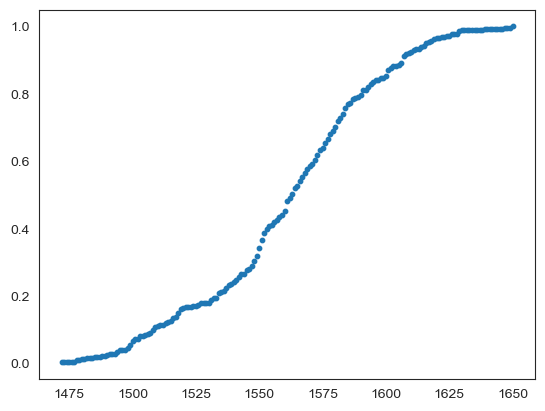

In [7]:
Min_Y = min(df['sourceYear'])
Max_Y = max(df['targetYear'])

List_Year_ID=list(zip(list(df['sourceYear']),list(df['sourceID'])))+list(zip(list(df['targetYear']),list(df['targetID'])))

year_books = {}
for year in range(Min_Y,Max_Y+1):    
    List2=[]
    for item in List_Year_ID:
        if item[0]==year:
            List2.append(item[1])
    year_books[year]=list(set(List2))

NBooks_eachY = []
for year in range(Min_Y,Max_Y+1):
    NBooks_eachY.append(len(year_books[year]))
    
years = []
for year in range(Min_Y,Max_Y+1):
    years.append(year)    

    
NBooks_eachY = np.array(NBooks_eachY)
i_t = NBooks_eachY.cumsum()/len(Sorted_book)
S_t=len(Sorted_book)-NBooks_eachY.cumsum()
S_t=S_t/len(Sorted_book)
        
plt.scatter(years,i_t,s=10,label='Aggregated of semantic')


In [8]:
EdgeList = list(df['links'])

Graph_directed = nx.DiGraph()
Graph_directed.add_edges_from(EdgeList)
NodesList = Graph_directed.nodes()
Node_out_dict = Dic_TargetList_of_All_Nodes(NodesList, EdgeList)

Node_targets = {}
for book in Sorted_book:
    Node_targets[book]=list(set(Node_out_dict[book]))

    

In [9]:
Infected = []
Infected_numbers = []
years_network = []

for year in range(Min_Y,Max_Y+1):    
    L = []
    if len(year_books[year]) != 0:        
        for book in year_books[year]:
            
            if book not in Infected:
                L.append(book)
            
            for i in Node_targets[book]:
                if i not in Infected:
                    L.append(i)

             
            for item in Node_targets[book]:
                if item not in Infected:
                    Infected.append(item)
            
            Infected.append(book)
            
            
            
    Infected_numbers.append(len(L))
    years_network.append(year)
    
               
            

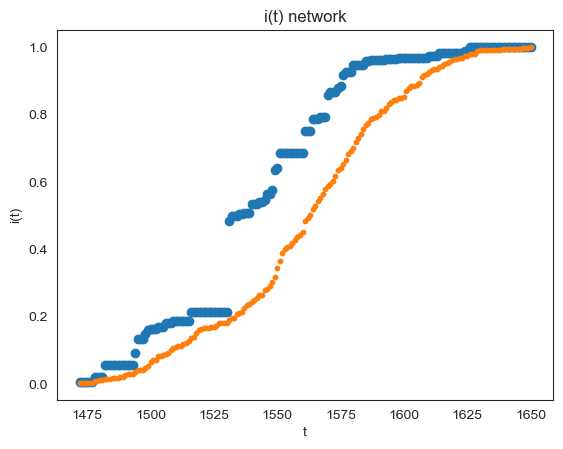

179
179


In [10]:
Infected_numbers = np.array(Infected_numbers)
i_t_network = Infected_numbers.cumsum()/len(Sorted_book)
S_t_network=len(Sorted_book)-Infected_numbers.cumsum()
S_t=S_t_network/len(Sorted_book)

plt.scatter(years_network,i_t_network)
plt.scatter(years,i_t,s=10,label='Aggregated of semantic')

plt.ylabel('i(t)')
plt.xlabel('t')
#plt.savefig('it_Se13_Se14_CompleteConnections')
plt.title('i(t) network')
plt.show()
    
print(len(years_network)) 
print(len(years))

## Try economic and awareness layers to see which ones are closer to the i(t) graph

In [11]:
# Economic layers
df_ec1 = pd.read_json('data_without100/ec1.json', lines=True).sort_values(by='sourceYear')
df_ec1_sameyear = df_ec1[df_ec1['sourceYear'] == df_ec1['targetYear']] 
df_ec1.drop(df_ec1_sameyear.index, inplace=True)

df_ec2 = pd.read_json('data_without100/ec2.json', lines=True).sort_values(by='sourceYear')
df_ec2_sameyear = df_ec2[df_ec2['sourceYear'] == df_ec2['targetYear']] 
df_ec2.drop(df_ec2_sameyear.index, inplace=True)

df_ec3 = pd.read_json('data_without100/ec3.json', lines=True).sort_values(by='sourceYear')
df_ec3_sameyear = df_ec3[df_ec3['sourceYear'] == df_ec3['targetYear']] 
df_ec3.drop(df_ec3_sameyear.index, inplace=True)


In [12]:
# awareness layers
df_aw1 = pd.read_json('data_without100/aw1.json', lines=True).sort_values(by='sourceYear')
df_aw1_sameyear = df_aw1[df_aw1['sourceYear'] == df_aw1['targetYear']] 
df_aw1.drop(df_aw1_sameyear.index, inplace=True)

df_aw2 = pd.read_json('data_without100/aw2.json', lines=True).sort_values(by='sourceYear')
df_aw2_sameyear = df_aw2[df_aw2['sourceYear'] == df_aw2['targetYear']] 
df_aw2.drop(df_aw2_sameyear.index, inplace=True)

df_aw3 = pd.read_json('data_without100/aw3.json', lines=True).sort_values(by='sourceYear')
df_aw3_sameyear = df_aw3[df_aw3['sourceYear'] == df_aw3['targetYear']] 
df_aw3.drop(df_aw3_sameyear.index, inplace=True)


In [13]:
df_ec1['links']=df_ec1[['sourceID','targetID']].apply(make_link,axis=1)

df_ec1['age-link']=df_ec1[['sourceYear','targetYear']].apply(links_age,axis=1)

df_ec1['same_city']=df_ec1[['source_book_location','target_book_location']].apply(from_same_city,axis=1)

df_ec1['link_city']=df_ec1[['source_book_location','target_book_location']].apply(link_city,axis=1)

df_ec1['same_format']=df_ec1[['source_book_format','target_book_format']].apply(from_same_format,axis=1)

df_ec1['name_of_same_format']=df_ec1[['source_book_format','target_book_format']].apply(same_format_name,axis=1)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

df_ec2['links']=df_ec2[['sourceID','targetID']].apply(make_link,axis=1)

df_ec2['age-link']=df_ec2[['sourceYear','targetYear']].apply(links_age,axis=1)

df_ec2['same_city']=df_ec2[['source_book_location','target_book_location']].apply(from_same_city,axis=1)

df_ec2['link_city']=df_ec2[['source_book_location','target_book_location']].apply(link_city,axis=1)

df_ec2['same_format']=df_ec2[['source_book_format','target_book_format']].apply(from_same_format,axis=1)

df_ec2['name_of_same_format']=df_ec2[['source_book_format','target_book_format']].apply(same_format_name,axis=1)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_ec3['links']=df_ec3[['sourceID','targetID']].apply(make_link,axis=1)

df_ec3['age-link']=df_ec3[['sourceYear','targetYear']].apply(links_age,axis=1)

df_ec3['same_city']=df_ec3[['source_book_location','target_book_location']].apply(from_same_city,axis=1)

df_ec3['link_city']=df_ec3[['source_book_location','target_book_location']].apply(link_city,axis=1)

df_ec3['same_format']=df_ec3[['source_book_format','target_book_format']].apply(from_same_format,axis=1)

df_ec3['name_of_same_format']=df_ec3[['source_book_format','target_book_format']].apply(same_format_name,axis=1)


In [14]:
df_aw1['links']=df_aw1[['sourceID','targetID']].apply(make_link,axis=1)

df_aw1['age-link']=df_aw1[['sourceYear','targetYear']].apply(links_age,axis=1)

df_aw1['same_city']=df_aw1[['source_book_location','target_book_location']].apply(from_same_city,axis=1)

df_aw1['link_city']=df_aw1[['source_book_location','target_book_location']].apply(link_city,axis=1)

df_aw1['same_format']=df_aw1[['source_book_format','target_book_format']].apply(from_same_format,axis=1)

df_aw1['name_of_same_format']=df_aw1[['source_book_format','target_book_format']].apply(same_format_name,axis=1)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

df_aw2['links']=df_aw2[['sourceID','targetID']].apply(make_link,axis=1)

df_aw2['age-link']=df_aw2[['sourceYear','targetYear']].apply(links_age,axis=1)

df_aw2['same_city']=df_aw2[['source_book_location','target_book_location']].apply(from_same_city,axis=1)

df_aw2['link_city']=df_aw2[['source_book_location','target_book_location']].apply(link_city,axis=1)

df_aw2['same_format']=df_aw2[['source_book_format','target_book_format']].apply(from_same_format,axis=1)

df_aw2['name_of_same_format']=df_aw2[['source_book_format','target_book_format']].apply(same_format_name,axis=1)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_aw3['links']=df_aw3[['sourceID','targetID']].apply(make_link,axis=1)

df_aw3['age-link']=df_aw3[['sourceYear','targetYear']].apply(links_age,axis=1)

df_aw3['same_city']=df_aw3[['source_book_location','target_book_location']].apply(from_same_city,axis=1)

df_aw3['link_city']=df_aw3[['source_book_location','target_book_location']].apply(link_city,axis=1)

df_aw3['same_format']=df_aw3[['source_book_format','target_book_format']].apply(from_same_format,axis=1)

df_aw3['name_of_same_format']=df_aw3[['source_book_format','target_book_format']].apply(same_format_name,axis=1)



In [15]:
# Make networks of awareness layers, considering just those links which are in common with semantic network

# aw1
EdgeList_aw1 = list(set(EdgeList).intersection(set(list(df_aw1['links']))))
Links_in_aw1_Not_in_Semantic = list(set(list(df_aw1['links'])) - set(EdgeList_aw1))

Graph_aw1 = nx.DiGraph()
Graph_aw1.add_edges_from(EdgeList_aw1)
NodesList_aw1 = Graph_aw1.nodes()
Node_out_dict_aw1 = Dic_TargetList_of_All_Nodes(NodesList_aw1, EdgeList_aw1)

Node_targets_aw1 = {}
for book in NodesList_aw1:
    Node_targets_aw1[book]=list(set(Node_out_dict_aw1[book]))

df_aw1 = df_aw1[~df_aw1['links'].isin(Links_in_aw1_Not_in_Semantic)]
    
    
# aw2
EdgeList_aw2 = list(set(EdgeList).intersection(set(list(df_aw2['links']))))
Links_in_aw2_Not_in_Semantic = list(set(list(df_aw2['links'])) - set(EdgeList_aw2))

Graph_aw2 = nx.DiGraph()
Graph_aw2.add_edges_from(EdgeList_aw2)
NodesList_aw2 = Graph_aw2.nodes()
Node_out_dict_aw2 = Dic_TargetList_of_All_Nodes(NodesList_aw2, EdgeList_aw2)

Node_targets_aw2 = {}
for book in NodesList_aw2:
    Node_targets_aw2[book]=list(set(Node_out_dict_aw2[book]))
    
df_aw2 = df_aw2[~df_aw2['links'].isin(Links_in_aw2_Not_in_Semantic)]

    
# aw3    
EdgeList_aw3 = list(set(EdgeList).intersection(set(list(df_aw3['links']))))
Links_in_aw3_Not_in_Semantic = list(set(list(df_aw3['links'])) - set(EdgeList_aw3))


Graph_aw3 = nx.DiGraph()
Graph_aw3.add_edges_from(EdgeList_aw3)
NodesList_aw3 = Graph_aw3.nodes()
Node_out_dict_aw3 = Dic_TargetList_of_All_Nodes(NodesList_aw3, EdgeList_aw3)

Node_targets_aw3 = {}
for book in NodesList_aw3:
    Node_targets_aw3[book]=list(set(Node_out_dict_aw3[book]))
   
df_aw3 = df_aw3[~df_aw3['links'].isin(Links_in_aw3_Not_in_Semantic)]


In [16]:
df_aw1.to_csv('df_aw1.csv')
df_aw2.to_csv('df_aw2.csv')
df_aw3.to_csv('df_aw3.csv')


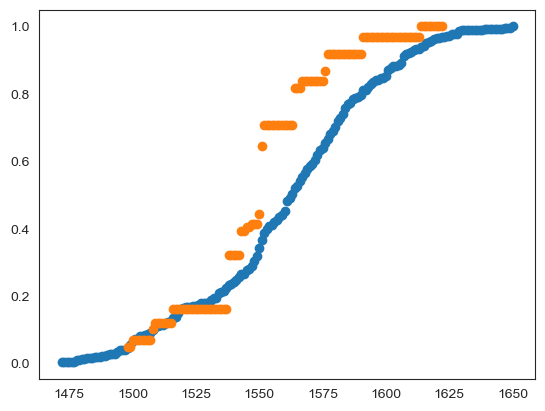

In [17]:
Min_Y_aw1=min(df_aw1['sourceYear'])
Max_Y_aw1=max(df_aw1['targetYear'])

aw1_Year_ID=list(zip(list(df_aw1['sourceYear']),list(df_aw1['sourceID'])))+list(zip(list(df_aw1['targetYear']),list(df_aw1['targetID'])))
year_books_aw1 = {}
for year in range(Min_Y_aw1,Max_Y_aw1+1):    
    List2=[]
    for item in aw1_Year_ID:
        if item[0]==year:
            List2.append(item[1])
    year_books_aw1[year]=list(set(List2))

    
Infected_aw1 = []
Infected_aw1_numbers = []
years_aw1 = []    

for year in range(Min_Y_aw1,Max_Y_aw1+1):    
    L = []
    if len(year_books_aw1[year]) != 0:        
        for book in year_books_aw1[year]:
            
            if book not in Infected_aw1:
                L.append(book)
            
            for i in Node_targets_aw1[book]:
                if i not in Infected_aw1:
                    L.append(i)

             
            for item in Node_targets_aw1[book]:
                if item not in Infected_aw1:
                    Infected_aw1.append(item)
            
            Infected_aw1.append(book)
            
            
            
    Infected_aw1_numbers.append(len(L))
    years_aw1.append(year)
    
Infected_aw1_numbers = np.array(Infected_aw1_numbers)
i_t_aw1_network = Infected_aw1_numbers.cumsum()/len(NodesList_aw1)                          


plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_aw1,i_t_aw1_network)




In [18]:
Min_Y_aw2=min(df_aw2['sourceYear'])
Max_Y_aw2=max(df_aw2['targetYear'])

aw2_Year_ID=list(zip(list(df_aw2['sourceYear']),list(df_aw2['sourceID'])))+list(zip(list(df_aw2['targetYear']),list(df_aw2['targetID'])))
year_books_aw2 = {}
for year in range(Min_Y_aw2,Max_Y_aw2+1):    
    List2=[]
    for item in aw2_Year_ID:
        if item[0]==year:
            List2.append(item[1])
    year_books_aw2[year]=list(set(List2))

    
Infected_aw2 = []
Infected_aw2_numbers = []
years_aw2 = []    

for year in range(Min_Y_aw2,Max_Y_aw2+1):    
    L = []
    if len(year_books_aw2[year]) != 0:        
        for book in year_books_aw2[year]:
            
            if book not in Infected_aw2:
                L.append(book)
            
            for i in Node_targets_aw2[book]:
                if i not in Infected_aw2:
                    L.append(i)

             
            for item in Node_targets_aw2[book]:
                if item not in Infected_aw2:
                    Infected_aw2.append(item)
            
            Infected_aw2.append(book)
            
            
            
    Infected_aw2_numbers.append(len(L))
    years_aw2.append(year)
    
Infected_aw2_numbers = np.array(Infected_aw2_numbers)
i_t_aw2_network = Infected_aw2_numbers.cumsum()/len(NodesList_aw2)                          


plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_aw2,i_t_aw2_network)




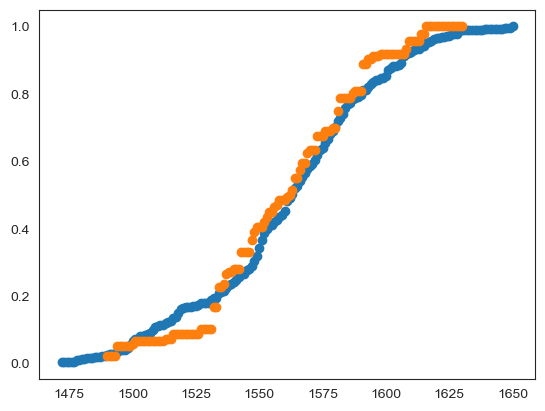

In [19]:
Min_Y_aw3=min(df_aw3['sourceYear'])
Max_Y_aw3=max(df_aw3['targetYear'])

aw3_Year_ID=list(zip(list(df_aw3['sourceYear']),list(df_aw3['sourceID'])))+list(zip(list(df_aw3['targetYear']),list(df_aw3['targetID'])))
year_books_aw3 = {}
for year in range(Min_Y_aw3,Max_Y_aw3+1):    
    List2=[]
    for item in aw3_Year_ID:
        if item[0]==year:
            List2.append(item[1])
    year_books_aw3[year]=list(set(List2))

    
Infected_aw3 = []
Infected_aw3_numbers = []
years_aw3 = []    

for year in range(Min_Y_aw3,Max_Y_aw3+1):    
    L = []
    if len(year_books_aw3[year]) != 0:        
        for book in year_books_aw3[year]:
            
            if book not in Infected_aw3:
                L.append(book)
            
            for i in Node_targets_aw3[book]:
                if i not in Infected_aw3:
                    L.append(i)

             
            for item in Node_targets_aw3[book]:
                if item not in Infected_aw3:
                    Infected_aw3.append(item)
            
            Infected_aw3.append(book)
            
            
            
    Infected_aw3_numbers.append(len(L))
    years_aw3.append(year)
    
Infected_aw3_numbers = np.array(Infected_aw3_numbers)
i_t_aw3_network = Infected_aw3_numbers.cumsum()/len(NodesList_aw3)                          


plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_aw3,i_t_aw3_network)



In [20]:

# Make networks of economic layers, considering just those links which are in common with semantic network

# ec1
EdgeList_ec1 = list(set(EdgeList).intersection(set(list(df_ec1['links']))))
Links_in_ec1_Not_in_Semantic = list(set(list(df_ec1['links'])) - set(EdgeList_ec1))

Graph_ec1 = nx.DiGraph()
Graph_ec1.add_edges_from(EdgeList_ec1)
NodesList_ec1 = Graph_ec1.nodes()
Node_out_dict_ec1 = Dic_TargetList_of_All_Nodes(NodesList_ec1, EdgeList_ec1)

Node_targets_ec1 = {}
for book in NodesList_ec1:
    Node_targets_ec1[book]=list(set(Node_out_dict_ec1[book]))

df_ec1 = df_ec1[~df_ec1['links'].isin(Links_in_ec1_Not_in_Semantic)]
    
    
# ec2
EdgeList_ec2 = list(set(EdgeList).intersection(set(list(df_ec2['links']))))
Links_in_ec2_Not_in_Semantic = list(set(list(df_ec2['links'])) - set(EdgeList_ec2))

Graph_ec2 = nx.DiGraph()
Graph_ec2.add_edges_from(EdgeList_ec2)
NodesList_ec2 = Graph_ec2.nodes()
Node_out_dict_ec2 = Dic_TargetList_of_All_Nodes(NodesList_ec2, EdgeList_ec2)

Node_targets_ec2 = {}
for book in NodesList_ec2:
    Node_targets_ec2[book]=list(set(Node_out_dict_ec2[book]))
    
df_ec2 = df_ec2[~df_ec2['links'].isin(Links_in_ec2_Not_in_Semantic)]

    
# ec3    
EdgeList_ec3 = list(set(EdgeList).intersection(set(list(df_ec3['links']))))
Links_in_ec3_Not_in_Semantic = list(set(list(df_ec3['links'])) - set(EdgeList_ec3))


Graph_ec3 = nx.DiGraph()
Graph_ec3.add_edges_from(EdgeList_ec3)
NodesList_ec3 = Graph_ec3.nodes()
Node_out_dict_ec3 = Dic_TargetList_of_All_Nodes(NodesList_ec3, EdgeList_ec3)

Node_targets_ec3 = {}
for book in NodesList_ec3:
    Node_targets_ec3[book]=list(set(Node_out_dict_ec3[book]))
   
df_ec3 = df_ec3[~df_ec3['links'].isin(Links_in_ec3_Not_in_Semantic)]


In [21]:
df_ec1.to_csv('df_ec1.csv')
df_ec2.to_csv('df_ec2.csv')
df_ec3.to_csv('df_ec3.csv')


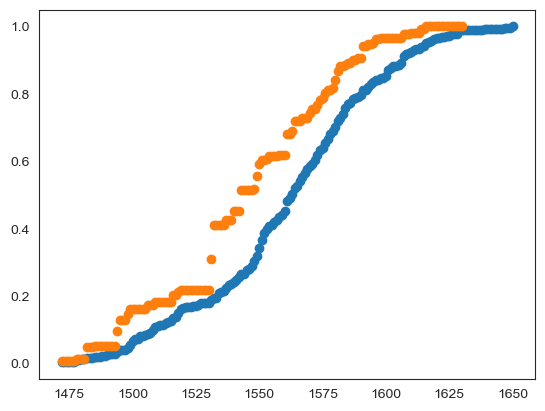

In [22]:

Min_Y_ec1=min(df_ec1['sourceYear'])
Max_Y_ec1=max(df_ec1['targetYear'])

ec1_Year_ID=list(zip(list(df_ec1['sourceYear']),list(df_ec1['sourceID'])))+list(zip(list(df_ec1['targetYear']),list(df_ec1['targetID'])))
year_books_ec1 = {}
for year in range(Min_Y_ec1,Max_Y_ec1+1):    
    List2=[]
    for item in ec1_Year_ID:
        if item[0]==year:
            List2.append(item[1])
    year_books_ec1[year]=list(set(List2))

    
Infected_ec1 = []
Infected_ec1_numbers = []
years_ec1 = []    

for year in range(Min_Y_ec1,Max_Y_ec1+1):    
    L = []
    if len(year_books_ec1[year]) != 0:        
        for book in year_books_ec1[year]:
            
            if book not in Infected_ec1:
                L.append(book)
            
            for i in Node_targets_ec1[book]:
                if i not in Infected_ec1:
                    L.append(i)

             
            for item in Node_targets_ec1[book]:
                if item not in Infected_ec1:
                    Infected_ec1.append(item)
            
            Infected_ec1.append(book)
            
            
            
    Infected_ec1_numbers.append(len(L))
    years_ec1.append(year)
    
Infected_ec1_numbers = np.array(Infected_ec1_numbers)
i_t_ec1_network = Infected_ec1_numbers.cumsum()/len(NodesList_ec1)                          


plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_ec1,i_t_ec1_network)




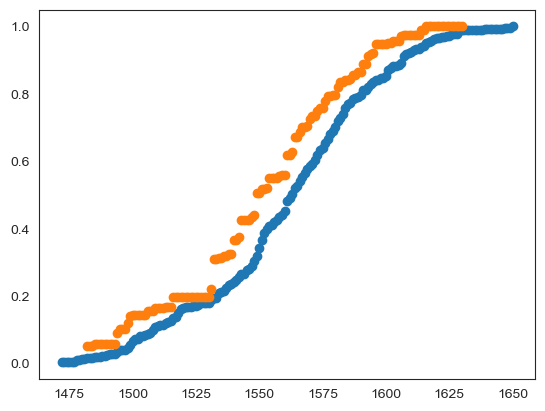

In [23]:
Min_Y_ec2=min(df_ec2['sourceYear'])
Max_Y_ec2=max(df_ec2['targetYear'])

ec2_Year_ID=list(zip(list(df_ec2['sourceYear']),list(df_ec2['sourceID'])))+list(zip(list(df_ec2['targetYear']),list(df_ec2['targetID'])))
year_books_ec2 = {}
for year in range(Min_Y_ec2,Max_Y_ec2+1):    
    List2=[]
    for item in ec2_Year_ID:
        if item[0]==year:
            List2.append(item[1])
    year_books_ec2[year]=list(set(List2))

    
Infected_ec2 = []
Infected_ec2_numbers = []
years_ec2 = []    

for year in range(Min_Y_ec2,Max_Y_ec2+1):    
    L = []
    if len(year_books_ec2[year]) != 0:        
        for book in year_books_ec2[year]:
            
            if book not in Infected_ec2:
                L.append(book)
            
            for i in Node_targets_ec2[book]:
                if i not in Infected_ec2:
                    L.append(i)

             
            for item in Node_targets_ec2[book]:
                if item not in Infected_ec2:
                    Infected_ec2.append(item)
            
            Infected_ec2.append(book)
            
            
            
    Infected_ec2_numbers.append(len(L))
    years_ec2.append(year)
    
Infected_ec2_numbers = np.array(Infected_ec2_numbers)
i_t_ec2_network = Infected_ec2_numbers.cumsum()/len(NodesList_ec2)                          


plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_ec2,i_t_ec2_network)




In [24]:
Min_Y_ec3=min(df_ec3['sourceYear'])
Max_Y_ec3=max(df_ec3['targetYear'])

ec3_Year_ID=list(zip(list(df_ec3['sourceYear']),list(df_ec3['sourceID'])))+list(zip(list(df_ec3['targetYear']),list(df_ec3['targetID'])))
year_books_ec3 = {}
for year in range(Min_Y_ec3,Max_Y_ec3+1):    
    List2=[]
    for item in ec3_Year_ID:
        if item[0]==year:
            List2.append(item[1])
    year_books_ec3[year]=list(set(List2))

    
Infected_ec3 = []
Infected_ec3_numbers = []
years_ec3 = []    

for year in range(Min_Y_ec3,Max_Y_ec3+1):    
    L = []
    if len(year_books_ec3[year]) != 0:        
        for book in year_books_ec3[year]:
            
            if book not in Infected_ec3:
                L.append(book)
            
            for i in Node_targets_ec3[book]:
                if i not in Infected_ec3:
                    L.append(i)

             
            for item in Node_targets_ec3[book]:
                if item not in Infected_ec3:
                    Infected_ec3.append(item)
            
            Infected_ec3.append(book)
            
            
            
    Infected_ec3_numbers.append(len(L))
    years_ec3.append(year)
    
Infected_ec3_numbers = np.array(Infected_ec3_numbers)
i_t_ec3_network = Infected_ec3_numbers.cumsum()/len(NodesList_ec3)                          


plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_ec3,i_t_ec3_network)



In [25]:
df_same_city = df[df['same_city']=='same city']
df_same_format = df[df['same_format']=='same format']


In [26]:
# same_city
EdgeList_same_city = list(set(list(df_same_city['links'])))

Graph_same_city = nx.DiGraph()
Graph_same_city.add_edges_from(EdgeList_same_city)
NodesList_same_city = Graph_same_city.nodes()
Node_out_dict_same_city = Dic_TargetList_of_All_Nodes(NodesList_same_city, EdgeList_same_city)

Node_targets_same_city = {}
for book in NodesList_same_city:
    Node_targets_same_city[book]=list(set(Node_out_dict_same_city[book]))



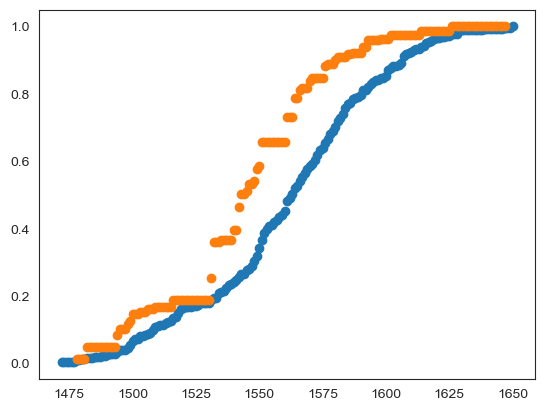

In [27]:
# same city
Min_Y_same_city=min(df_same_city['sourceYear'])
Max_Y_same_city=max(df_same_city['targetYear'])

same_city_Year_ID=list(zip(list(df_same_city['sourceYear']),list(df_same_city['sourceID'])))+list(zip(list(df_same_city['targetYear']),list(df_same_city['targetID'])))
year_books_same_city = {}
for year in range(Min_Y_same_city,Max_Y_same_city+1):    
    List2=[]
    for item in same_city_Year_ID:
        if item[0]==year:
            List2.append(item[1])
    year_books_same_city[year]=list(set(List2))

    
Infected_same_city = []
Infected_same_city_numbers = []
years_same_city = []    

for year in range(Min_Y_same_city,Max_Y_same_city+1):    
    L = []
    if len(year_books_same_city[year]) != 0:        
        for book in year_books_same_city[year]:
            
            if book not in Infected_same_city:
                L.append(book)
            
            for i in Node_targets_same_city[book]:
                if i not in Infected_same_city:
                    L.append(i)

             
            for item in Node_targets_same_city[book]:
                if item not in Infected_same_city:
                    Infected_same_city.append(item)
            
            Infected_same_city.append(book)
            
            
            
    Infected_same_city_numbers.append(len(L))
    years_same_city.append(year)
    
Infected_same_city_numbers = np.array(Infected_same_city_numbers)
i_t_same_city_network = Infected_same_city_numbers.cumsum()/len(NodesList_same_city)                          


plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_same_city,i_t_same_city_network)



In [28]:
# same_format
EdgeList_same_format = list(set(list(df_same_format['links'])))

Graph_same_format = nx.DiGraph()
Graph_same_format.add_edges_from(EdgeList_same_format)
NodesList_same_format = Graph_same_format.nodes()
Node_out_dict_same_format = Dic_TargetList_of_All_Nodes(NodesList_same_format, EdgeList_same_format)

Node_targets_same_format = {}
for book in NodesList_same_format:
    Node_targets_same_format[book]=list(set(Node_out_dict_same_format[book]))



In [29]:
# same format
Min_Y_same_format=min(df_same_format['sourceYear'])
Max_Y_same_format=max(df_same_format['targetYear'])

same_format_Year_ID=list(zip(list(df_same_format['sourceYear']),list(df_same_format['sourceID'])))+list(zip(list(df_same_format['targetYear']),list(df_same_format['targetID'])))
year_books_same_format = {}
for year in range(Min_Y_same_format,Max_Y_same_format+1):    
    List2=[]
    for item in same_format_Year_ID:
        if item[0]==year:
            List2.append(item[1])
    year_books_same_format[year]=list(set(List2))

    
Infected_same_format = []
Infected_same_format_numbers = []
years_same_format = []    

for year in range(Min_Y_same_format,Max_Y_same_format+1):    
    L = []
    if len(year_books_same_format[year]) != 0:        
        for book in year_books_same_format[year]:
            
            if book not in Infected_same_format:
                L.append(book)
            
            for i in Node_targets_same_format[book]:
                if i not in Infected_same_format:
                    L.append(i)

             
            for item in Node_targets_same_format[book]:
                if item not in Infected_same_format:
                    Infected_same_format.append(item)
            
            Infected_same_format.append(book)
            
            
            
    Infected_same_format_numbers.append(len(L))
    years_same_format.append(year)
    
Infected_same_format_numbers = np.array(Infected_same_format_numbers)
i_t_same_format_network = Infected_same_format_numbers.cumsum()/len(NodesList_same_format)                          


plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_same_format,i_t_same_format_network)



## Change tick size

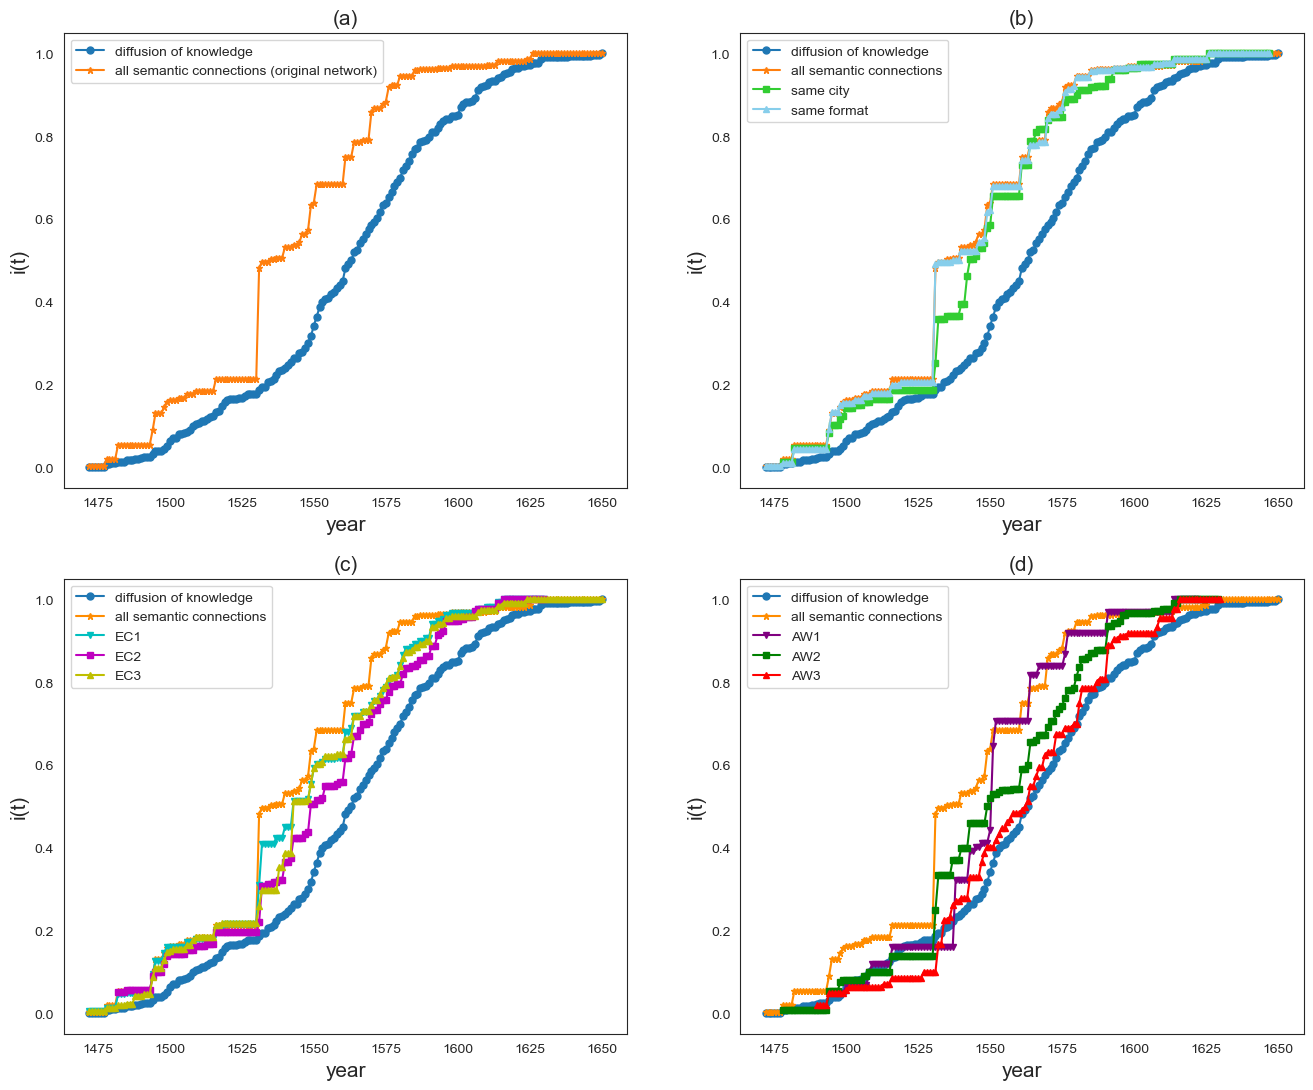

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(16, 13))


axes[0,0].plot(years,i_t, marker='o',markersize=5, label='diffusion of knowledge')
axes[0,0].plot(years_network,i_t_network,marker='*',markersize=5,label='all semantic connections (original network)')   # This is with Betha = 0.0626
axes[0,0].legend()
axes[0,0].set_title('(a)',size=15)
axes[0,0].set_ylabel('i(t)',size=15)
axes[0,0].set_xlabel('year',size=15)


axes[0,1].plot(years,i_t, marker='o',markersize=5, label='diffusion of knowledge')
axes[0,1].plot(years_network,i_t_network,marker='*',markersize=5,label='all semantic connections')   # This is with Betha = 0.0626
axes[0,1].plot(years_same_city,i_t_same_city_network,marker='s',markersize=5,c='limegreen',label='same city')   # This is with Betha = 0.0626
axes[0,1].plot(years_same_format,i_t_same_format_network,marker='^',markersize=5,c='skyblue',label='same format')   # This is with Betha = 0.0626
axes[0,1].legend()
axes[0,1].set_title('(b)',size=15)
axes[0,1].set_ylabel('i(t)',size=15)
axes[0,1].set_xlabel('year',size=15)


axes[1,0].plot(years,i_t, marker='o',markersize=5, label='diffusion of knowledge')
axes[1,0].plot(years_network,i_t_network,marker='*', c='darkorange',markersize=5,label='all semantic connections')   # This is with Betha = 0.0626
axes[1,0].plot(years_ec1,i_t_ec1_network,marker='v',markersize=5,c='c',label='EC1')   # This is with Betha = 0.0626
axes[1,0].plot(years_ec2,i_t_ec2_network,marker='s',markersize=5,c='m',label='EC2')   # This is with Betha = 0.0626
axes[1,0].plot(years_ec3,i_t_ec3_network,marker='^',markersize=5,c='y',label='EC3')   # This is with Betha = 0.0626
axes[1,0].legend()
axes[1,0].set_title('(c)',size=15)
axes[1,0].set_ylabel('i(t)',size=15)
axes[1,0].set_xlabel('year',size=15)


axes[1,1].plot(years,i_t, marker='o',markersize=5, label='diffusion of knowledge')
axes[1,1].plot(years_network,i_t_network,marker='*', c='darkorange',markersize=5,label='all semantic connections')   # This is with Betha = 0.0626
axes[1,1].plot(years_aw1,i_t_aw1_network,marker='v',markersize=5,c='purple',label='AW1')   # This is with Betha = 0.0626
axes[1,1].plot(years_aw2,i_t_aw2_network,marker='s',markersize=5,c='green',label='AW2')   # This is with Betha = 0.0626
axes[1,1].plot(years_aw3,i_t_aw3_network,marker='^',markersize=5,c='red',label='AW3')   # This is with Betha = 0.0626
axes[1,1].legend()
axes[1,1].set_title('(d)',size=15)
axes[1,1].set_ylabel('i(t)',size=15)
axes[1,1].set_xlabel('year',size=15)


plt.savefig('It_Find_Best_network.pdf')
plt.show()



In [55]:
from sklearn.metrics import r2_score
itO = []
itAW3 = []
for year in years: 
    index1 = years.index(year)
    if year in years_aw3:
        index2 = years_aw3.index(year)
        itO.append(i_t[index1])
        itAW3.append(i_t_aw3_network[index2])

r2_score(itO, itAW3)


0.9814870549941592

In [51]:
from sklearn.metrics import r2_score
itO = []
itEC3 = []
for year in years: 
    index1 = years.index(year)
    if year in years_ec3:
        index2 = years_ec3.index(year)
        itO.append(i_t[index1])
        itEC3.append(i_t_ec3_network[index2])

r2_score(itO, itEC3)

0.9172148496951702

In [45]:
print(len(i_t))
len(i_t_ec1_network)

179


159

In [48]:
from sklearn.metrics import r2_score

r2_all_semantic_connections = r2_score(i_t, i_t_network)

print("R-squared for all semantic connections:", r2_all_semantic_connections)


R-squared for all semantic connections: 0.8209992589584751


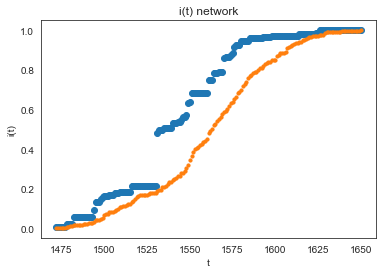

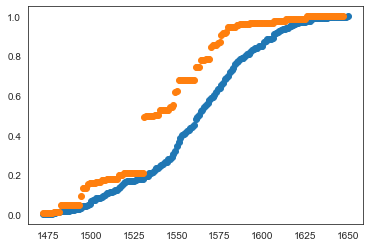

In [131]:
plt.scatter(years_network,i_t_network)
plt.scatter(years,i_t,s=10,label='Aggregated of semantic')

plt.ylabel('i(t)')
plt.xlabel('t')
#plt.savefig('it_Se13_Se14_CompleteConnections')
plt.title('i(t) network')
plt.show()

plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_same_format,i_t_same_format_network)
plt.show()

plt.scatter(years,i_t,label='Aggregated of semantic')
plt.scatter(years_aw1,i_t_aw1_network)
plt.show()


# find the graph with first neighbor connection 
G_first_neighbor = nx.DiGraph()

Targets=list(set(list(df['targetID'])))
for book in Targets:

    df_book=df[df['targetID']==book]

    Min_age = min(df_book['age-link'])

    df_book_minage=df_book[df_book['age-link']==Min_age]
    G_first_neighbor.add_edges_from(list(set(list(df_book_minage['links']))))
        



EdgeList_firstneighbor = list(G_first_neighbor.edges())
NodesList_firstneighbor = list(G_first_neighbor.nodes())
Node_out_dict_firstneighbor = Dic_TargetList_of_All_Nodes(NodesList_firstneighbor, EdgeList_firstneighbor)


Node_targets_firstneighbor = {}
for book in Node_out_dict_firstneighbor:
    Node_targets_firstneighbor[book]=list(set(Node_out_dict_firstneighbor[book]))



Infected_firstNeighbor = []

Infected_firstNeighbor_numbers = []
years2 = []
sortedbook_G_firstneighbor = []
for book in Sorted_book:
    if book in NodesList_firstneighbor:
        sortedbook_G_firstneighbor.append(book)
        
        
for book in sortedbook_G_firstneighbor:
    L = []
    for i in Node_targets_firstneighbor[book]:
        if i not in Infected_firstNeighbor:
            L.append(i)
    if book not in Infected_firstNeighbor:
        L.append(book)
        
    Infected_firstNeighbor_numbers.append(len(L))
    Infected_firstNeighbor.append(book)
    #Infected_firstNeighbor_numbers.append(len([i for i in Node_out_dict[book] if i not in Infected_firstNeighbor]))
    for item in Node_targets_firstneighbor[book]:
        if item not in Infected_firstNeighbor:
            Infected_firstNeighbor.append(item)
        
    years2.append(Dic_books_year[book])
        
Infected_firstNeighbor_numbers = np.array(Infected_firstNeighbor_numbers)
i_t_firstNeighbor = Infected_firstNeighbor_numbers.cumsum()/len(sortedbook_G_firstneighbor)
S_t_firstNeighbor=len(sortedbook_G_firstneighbor)-Infected_firstNeighbor_numbers.cumsum()
S_t_firstNeighbor=S_t_firstNeighbor/len(sortedbook_G_firstneighbor)

plt.scatter(years2,i_t_firstNeighbor,label='firstNeighbor')
plt.scatter(years,i_t,label='Aggregated of semantic')
plt.legend()
plt.ylabel('i(t)')
plt.xlabel('t')
#plt.savefig('it_firstNeighbor_Se14_Se15')
plt.title('i(t) for layers firstNeighbor and Se14')
plt.show()

                

def FindInfected(Graph):
    edgelist = list(Graph.edges)
    nodelist = list(Graph.nodes())
    node_out_dict = Dic_TargetList_of_All_Nodes(nodelist, edgelist)
    
    node_targets_new = {}
    for node in node_out_dict:
        node_targets_new[node] = list(set(node_out_dict[node]))
        
    Infected = []
    Infected_numbers = []
    years = []
    
    Newsorted_book = []
    for node in Sorted_book:
        if node in nodelist:
            Newsorted_book.append(node)
            
    for node in Newsorted_book:
        L = []
        for i in node_targets_new[node]:
            if i not in Infected:
                L.append(i)
        Infected_numbers.append(len(L))
        
        for item in node_targets_new[node]:
            if item not in Infected:
                Infected.append(item)
        years.append(Dic_books_year[node])
        
    return Infected_numbers, years, Newsorted_book



In [138]:
EdgeList = list(set(list(df['links'])))

SampleEdge_list23 = {}
Sample_subgraph23 = {}
SampleNodes_list23 = {}

N23=int(len(EdgeList)*2/3)

SampleInfected23 = {}
SampleYears23 = {}
SampleSortedbook23 = {}
Sample_It23 = {}

for i in range(5):
    SampleEdge_list23[i]=random.sample(EdgeList,N23)
    Sample_subgraph23[i]=nx.DiGraph()
    Sample_subgraph23[i].add_edges_from(SampleEdge_list23[i])
    SampleNodes_list23[i]=list(Sample_subgraph23[i].nodes())
    SampleInfected23[i], SampleYears23[i], SampleSortedbook23[i] = FindInfected(Sample_subgraph23[i])
    SampleInfected23[i] = np.array(SampleInfected23[i])
    Sample_It23[i]=SampleInfected23[i].cumsum()/len(SampleSortedbook23[i])
    


    
SampleEdge_list13 = {}
Sample_subgraph13 = {}
SampleNodes_list13 = {}    
    
N13=int(len(EdgeList)*1/3)

SampleInfected13 = {}
SampleYears13 = {}
SampleSortedbook13 = {}
Sample_It13 = {}

for i in range(5):
    SampleEdge_list13[i]=random.sample(EdgeList,N13)
    Sample_subgraph13[i]=nx.DiGraph()
    Sample_subgraph13[i].add_edges_from(SampleEdge_list13[i])
    SampleNodes_list13[i]=list(Sample_subgraph13[i].nodes())
    SampleInfected13[i], SampleYears13[i], SampleSortedbook13[i] = FindInfected(Sample_subgraph13[i])
    SampleInfected13[i] = np.array(SampleInfected13[i])
    Sample_It13[i]=SampleInfected13[i].cumsum()/len(SampleSortedbook13[i])
    






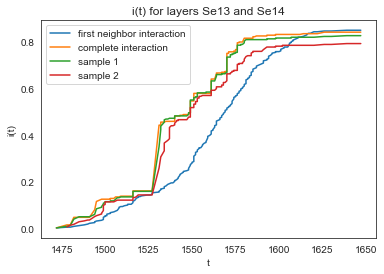

In [139]:
plt.plot(years2,i_t_firstNeighbor,label='first neighbor interaction')
plt.plot(years,i_t_Se13,label='complete interaction')
plt.plot(SampleYears23[0],Sample_It23[0],label='sample 1')
plt.plot(SampleYears13[0],Sample_It13[0],label='sample 2')
plt.legend()
plt.ylabel('i(t)')
plt.xlabel('t')
plt.title('i(t) for layers Se13 and Se14')
#plt.savefig('it_Se13_Se14_Complete_firstneighborConnections')

plt.show()


